<a href="https://colab.research.google.com/github/agamsaikumar10/hair-removal/blob/master/Hair_removal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install numpy scipy scikit-image matplotlib


In [ ]:
pip install GDAL


In [ ]:
!pip install numpy scipy scikit-image matplotlib
# And if you need GDAL
!pip install GDAL


In [ ]:
import logging
import math

import numpy as np
from skimage import img_as_float
from softcolor import MorphologyInCIELab

logger = logging.getLogger(__name__)


def remove_and_inpaint(image, tophats_se=None, inpainting_se=None):
    image = img_as_float(image)

    if tophats_se is None:
        logger.info('Creating structuring elements for top hat.')
        tophats_se = bank_of_structuring_elements(side_enclosing_square_in_px=9, num_orientations=8)
    if inpainting_se is None:
        logger.info('Creating structuring element for inpainting.')
        inpainting_se = np.ones((5, 5), dtype='float32')

    morphology = MorphologyInCIELab()

    tophats_as_list = []
    for idx, se in enumerate(tophats_se):
        logger.info(f'Computing top-hat {idx+1:02d}/{len(tophats_se):02d}.')
        tophats_as_list.append(morphology.tophat_closing(image, structuring_element=se))

    tophats = np.stack(tophats_as_list, axis=2)     # THs are 2D, so are to be stacked on 3rd dim.

    logger.info('Computing curvilinear detector output.')
    curvilinear_detector = np.max(tophats, axis=2) - np.min(tophats, axis=2)
    curvilinear_detector -= np.min(curvilinear_detector)
    if np.max(curvilinear_detector) > 0:
        curvilinear_detector /= np.max(curvilinear_detector)

    curvilinear_mask = curvilinear_detector > 0.1

    image_to_inpaint = image.copy()
    image_to_inpaint[curvilinear_mask] = np.nan

    logger.info('Inpainting image.')
    inpainted_image, inpaint_steps = morphology.inpaint_with_steps(image_to_inpaint, structuring_element=inpainting_se)

    tophats_as_list_normalized = [t - np.min(t) for t in tophats_as_list]
    tophats_as_list_normalized = [t/np.max(t) for t in tophats_as_list_normalized]
    image_to_inpaint[np.isnan(image_to_inpaint)] = 1    # Inpaint with white for visualization

    steps = [v for tupl in zip(tophats_se, tophats_as_list_normalized) for v in tupl] + \
            [curvilinear_detector, curvilinear_mask] + \
            [s for s in inpaint_steps]

    return inpainted_image, steps


def bank_of_structuring_elements(side_enclosing_square_in_px, num_orientations):
    return [se_bar(side_enclosing_square_in_px=side_enclosing_square_in_px, orientation_in_degrees=a)
            for a in np.linspace(start=0, stop=180, num=num_orientations, endpoint=False)]


def se_bar(side_enclosing_square_in_px, orientation_in_degrees):
    se_sz = side_enclosing_square_in_px
    sz_ct = side_enclosing_square_in_px // 2
    m = -math.tan(math.radians(orientation_in_degrees))
    [coord_x, coord_y] = np.meshgrid(range(-sz_ct, se_sz-sz_ct), range(-sz_ct, se_sz-sz_ct))

    if m > 1e15:
        distance_to_line = np.abs(coord_x)
    else:
        distance_to_line = np.abs(m * coord_x - coord_y) / math.sqrt(m ** 2 + 1)

    variance = max(1/2, se_sz/14)
    structuring_element = np.exp(-distance_to_line**2 / (2*variance))
    return structuring_element

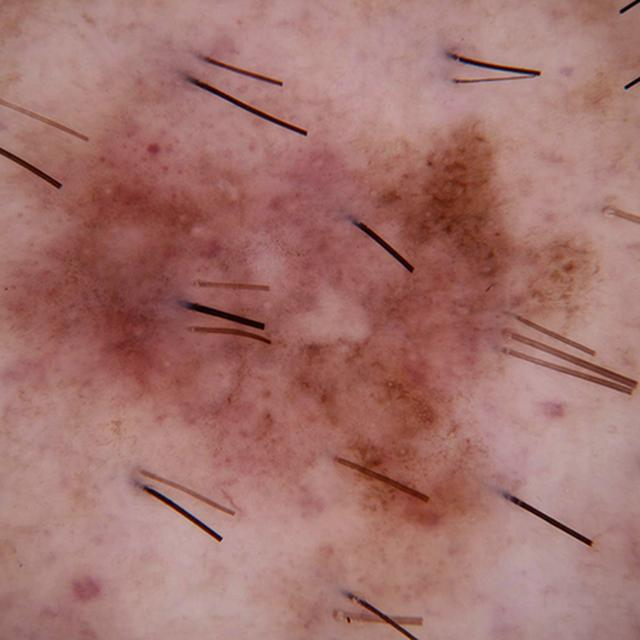

In [ ]:
import numpy as np
import math
from skimage import img_as_float, morphology, color, io, filters, restoration

def remove_hair(image):
    # Convert to grayscale
    if len(image.shape) > 2:
        image = color.rgb2gray(image)
    image = img_as_float(image)

    # Generate a bank of structuring elements with different orientations
    orientations = 8
    length = 10  # This parameter may need to be tuned
    structuring_elements = [morphology.rectangle(length, 1)]
    for i in range(1, orientations):
        rotated_selem = morphology.rotate(structuring_elements[0], angle=i*(180/orientations))
        structuring_elements.append(rotated_selem)


    tophat_images = [filters.rank.black_tophat(image, selem=selem) for selem in structuring_elements]


    combined_tophat = np.max(tophat_images, axis=0)


    thresh = filters.threshold_otsu(combined_tophat)
    hair_mask = combined_tophat > thresh

    # Use inpainting to reconstruct the image without hair
    inpainted_image = restoration.inpaint.inpaint_biharmonic(image, mask=hair_mask)

    return inpainted_image

# Usage
image_path = '/content/drive/MyDrive/ISIC_0024323.jpg'
image = io.imread(image_path)
inpainted_image = remove_hair(image)

# Save the result
output_path = '/content/drive/MyDrive/Colab Notebooks'
io.imsave(output_path, inpainted_image)


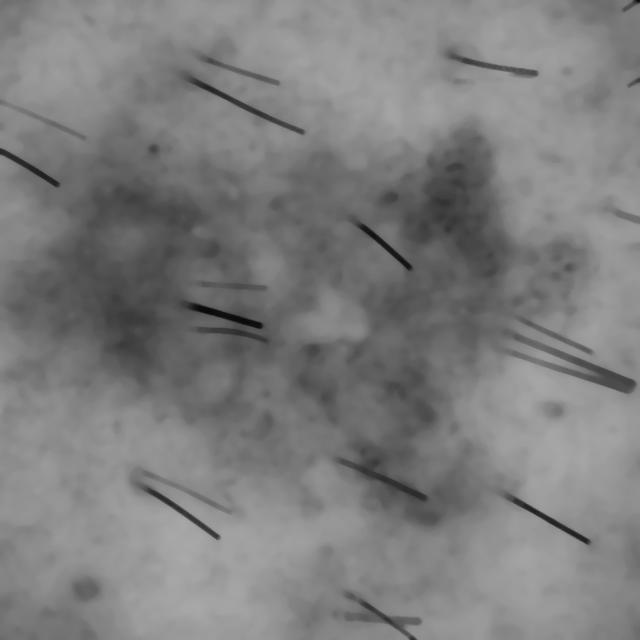